## Make a feature-centric eddy composite, v5
##### New updates from v4: add more interative capabilities so eddy composites (both surface and vertical) can be made for each month

In [1]:
import eddy_tracks
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.interpolate
import metpy.calc as mpcalc
import math

### Define some functions

In [2]:
def calc_distance(eddy,xlen,ylen,eddy_tracks):
    
    distances= np.empty([ylen, xlen])
    
    #Haversine formula, assumes Earth is a sphere
    R = 6373.0 #radius of earth (km)

    lat1 = eddy_tracks.y.iloc[eddy]
    lon1 = eddy_tracks.x.iloc[eddy]

    lat2 = ds.TLAT
    lon2 = ds.TLONG

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = (np.sin(dlat / 2) * np.sin(dlat / 2) +
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) *
         np.sin(dlon / 2) * np.sin(dlon / 2))

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distances = R * c
    return distances

In [3]:
def put_coords(databox):

        #first do lons
        start = -1*int(len(databox.lon)/2)
        if len(databox.lon)%2 == 0.:
            end=int(len(databox.lon)/2)
        else:
            end=int(len(databox.lon)/2 + 1)

        databox['lon']=np.arange(start,end,1)

        #now do lats
        start = -1*int(len(databox.lat)/2)

        if len(databox.lat)%2 == 0.:
            end=int(len(databox.lat)/2)
        else:
            end=int(len(databox.lat)/2 + 1)

        databox['lat']=np.arange(start,end,1) # databox = databox.assign_coords({'lat':np.arange(start,end,1)})

        return databox

In [4]:
def composite_a_2D_eddy(eddy_tracks, ds, var, n_reps, threshold_r):

    xlen=len(ds.nlon)
    ylen=len(ds.nlat)
    elen=len(eddy_tracks)
    
    #initialize sum
    sum_databoxes = 0
    count_eddies = 0

    for eddy in np.arange(0,elen,1):
        #print("starting eddy ", eddy)

        distance = calc_distance(eddy,xlen,ylen,eddy_tracks)

        #normalize distance to eddy radius
        distance_normrad = distance / eddy_tracks.radius_km.iloc[eddy]

        #extract just these values
        sorted_distances = np.sort(distance_normrad, axis=None)
        sorted_distances = sorted_distances[sorted_distances < threshold_r]
        limit_index=len(sorted_distances)

        #get the x,y indices of the qualifying gridcells
        indices = np.unravel_index(np.argsort(distance_normrad.data, axis=None), distance_normrad.shape)

        #make a subset based on the limit index for qualifying distances
        indices_subset = (indices[0][:limit_index],indices[1][:limit_index])

        #get the four indices for getting out hi res data in the box
        x_min, x_max=np.percentile(indices_subset[0], [0,100])
        y_min, y_max=np.percentile(indices_subset[1], [0,100])
        x_min = int(x_min)
        x_max = int(x_max)
        y_min = int(y_min)
        y_max = int(y_max)

        #extract data for the variable with these indices
        databox = var[x_min:x_max,y_min:y_max] # databox = var.isel(lon=slice(x_min,x_max+1), lat=slice(y_min,y_max+1))

        if np.isnan(databox).any() != True:

            count_eddies = count_eddies + 1

            #make databox an xr DataArray
            databox = xr.DataArray(databox,dims=('lat','lon'))

            databox_smooth = mpcalc.smooth_n_point(databox, 9, n_reps)
            databox_smooth = xr.DataArray(databox_smooth,dims=('lat','lon'))
            databox_smooth.attrs = databox.attrs

            #make it anomalies
            databox = databox - databox_smooth

            #put data in the coordinates so that the eddies can be overlaid with their centers aligned
            databox = put_coords(databox)

            #now make a running sum
            sum_databoxes = sum_databoxes + databox     

        else:
            print('skipping eddy number', eddy)

    #finally, out of the loop, divide by the eddy number so that we have mean
    composite = sum_databoxes / count_eddies
    composite['lat']=sum_databoxes['lat']
    composite['lon']=sum_databoxes['lon']
    
    return composite, count_eddies, sum_databoxes

In [5]:
def composite_a_3D_eddy(eddy_tracks, ds, var, n_reps, threshold_r):
    print('got a 3-d var')
    xlen=len(ds.nlon)
    ylen=len(ds.nlat)
    elen=len(eddy_tracks)

    #initialize sum
    sum_databoxes = 0
    count_eddies = 0

    ###########first see if there are eddies with nans

    eddy_list=[]
    eddies_dict = dict()


    if var.dims[0]=='z_t':
        z_dim = 'z_t'
    else:
        z_dim = 'z_t_150m'

    for eddy in np.arange(0,elen,1):
        #print(eddy)
        distance = calc_distance(eddy,xlen,ylen,eddy_tracks)

        #normalize distance to eddy radius
        distance_normrad = distance / eddy_tracks.radius_km.iloc[eddy]

        #extract just these values
        sorted_distances = np.sort(distance_normrad, axis=None)
        sorted_distances = sorted_distances[sorted_distances < threshold_r]
        limit_index=len(sorted_distances)

        #get the x,y indices of the qualifying gridcells
        indices = np.unravel_index(np.argsort(distance_normrad.data, axis=None), distance_normrad.shape)

        #make a subset based on the limit index for qualifying distances
        indices_subset = (indices[0][:limit_index],indices[1][:limit_index])

        #get the four indices for getting out hi res data in the box
        x_min, x_max=np.percentile(indices_subset[0], [0,100])
        y_min, y_max=np.percentile(indices_subset[1], [0,100])
        x_min = int(x_min)
        x_max = int(x_max)
        y_min = int(y_min)
        y_max = int(y_max)

        databox = var[0:15, x_min:x_max, y_min:y_max]

        #make databox an xr DataArray
        databox = xr.DataArray(databox,dims=(z_dim,'lat','lon'))

        if np.isnan(var[0:15,x_min:x_max,y_min:y_max]).any() != True:
            eddy_list.append(eddy)
            
            #saving each individual eddy composite ds in a dictionary
            eddy_str = str(eddy)
            eddies_dict[eddy_str] = databox
            
            #finding minimum eddy size so that a sums array can be set up 
            if count_eddies==0:
                width=len(databox.lon)
                height=len(databox.lat)
            else:
                width=(min(width, len(databox.lon)))
                height=(min(height, len(databox.lat)))
                
            count_eddies = count_eddies + 1
            
    #prepare array for summing
    sums3d = xr.DataArray(np.zeros([15,height,width]),dims=(z_dim,'lat','lon'))

    for z in np.arange(0,15,1):

        #print('doing depth',z)
        if z_dim=='z_t':
            var2d = var.isel(z_t=z).squeeze()
        else:
            var2d = var.isel(z_t_150m=z).squeeze()

        for eddy in eddy_list:

            eddy_str = str(eddy)

            databox = eddies_dict[eddy_str][z,:,:].squeeze()

            databox_smooth = mpcalc.smooth_n_point(databox, 9, n_reps)
            databox_smooth = xr.DataArray(databox_smooth,dims=('lat','lon'))
            databox_smooth.attrs = databox.attrs

            #make it anomalies
            databox = databox - databox_smooth

            #put data in the coordinates so that the eddies can be overlaid with their centers aligned
            databox = put_coords(databox)

            #now make a running sum
            sum_databoxes = sum_databoxes + databox 

        sums3d[z,:,:]=sum_databoxes
        count_eddies=len(eddy_list)
    
    composite = sums3d / count_eddies
    composite['lat']=sum_databoxes['lat']
    composite['lon']=sum_databoxes['lon']
    
    return composite, count_eddies, sums3d

### get the tracks

In [6]:
pth = '/glade/p/cgd/oce/people/mclong/hi-res-eco/data/analysis/tracks_20161128'
file_in = f'{pth}/0_pt_1_CESM_tracks.mat'
tracks = pd.DataFrame(eddy_tracks.track_mat2py(file_in))
tracks = tracks.rename(columns={"Ls": "radius_km"})
tracks

,x,y,amp,area,u,age,radius_km,id,cyc,year,mon,day
0,242.258195,40.498931,2.994491,10809.049919,NaN,10.0,58.656862,1,1,1,1,5
1,242.600100,-69.344310,0.125429,1307.723710,NaN,10.0,20.402485,2,1,1,1,5
2,242.700100,-64.131685,3.458723,6708.039396,5.631560,10.0,46.208606,3,1,1,1,5
3,245.400100,-61.955224,13.669557,10985.213312,26.323848,10.0,59.132918,4,1,1,1,5
4,245.600100,-67.146695,0.551876,1666.310001,NaN,10.0,23.030479,5,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1599345,258.500100,-63.513617,6.218261,9476.326775,11.992946,125.0,54.921840,230803,-1,5,12,31
1599346,258.600100,-55.425356,2.878914,6293.522627,8.810720,35.0,44.758133,236814,-1,5,12,31
1599347,258.600100,-49.654134,0.655865,8606.090785,NaN,55.0,52.339314,235516,-1,5,12,31
1599348,258.800100,-21.714382,0.378134,8417.142072,NaN,20.0,51.761564,237872,-1,5,12,31


### make a dictionary of the hi-res days for each month

In [7]:
day_dict = {
        "jan" : (5,10,15,20,25,30),
        "feb" : (4,9,14,19,24),
        "mar" : (1,6,11,16,21,26,31),
        "apr" : (5,10,15,20,25,30),
        "may" : (5,10,15,20,25,30),
        "jun" : (4,9,14,19,24,29),
        "jul" : (4,9,14,19,24,29),
        "aug" : (3,8,13,18,23,28),
        "sep" : (2,7,12,17,22,27),
        "oct" : (2,7,12,17,22,27),
        "nov" : (1,6,11,16,21,26),
        "dec" : (1,6,11,16,21,26,31)
        }

month_dict = {
        "jan" : 1,
        "feb" : 2,
        "mar" : 3,
        "apr" : 4,
        "may" : 5,
        "jun" : 6,
        "jul" : 7,
        "aug" : 8,
        "sep" : 9,
        "oct" : 10,
        "nov" : 11,
        "dec" : 12
        }

In [8]:
for month in month_dict:
    print(month)

jan
feb
mar
apr
may
jun
jul
aug
sep
oct
nov
dec


In [9]:
month_dict['dec']

12

#### set variables, select tracks, make eddy composites, saving them in a dataset

In [10]:
%%time
#first set variables and eddy characteristics
variables = ['SSH','diatChl','NO3','spChl'] #'PO4','TEMP','diat_N_lim','SSH','NO3','spC','Fe'] ############### set here!!

lat_max=-45
lat_min=-55
lon_max=135
lon_min=0

n_reps = 20      # number of repetitions for 9 pt smoother of databox
threshold_r=4    #radius normalized distance threshold for including in composite

age_min=30     #eddy age in days
amp_min=1      #eddy amplitude in cm
year=5        #year of high res run       

radius_min=55
radius_max=65

#make empty dictionary to save the composite datasets for each month
Cyclonic_monthly = dict()
Anticyclonic_monthly = dict()
vars2d = []
vars3d = []
#for month_name in month_dict:
for month_name in ['dec','jun','jan','jul']:
    
    print('------starting month', month_name,'-----------')
    
    month=month_dict[month_name]

    valid_eddies_cyc_sum=0
    valid_eddies_anticyc_sum=0
    counter=0
    for day in day_dict[month_name]:
        print('doing day', counter)
        #sort by age, amplitude, size, lon/lat range, and eddy type
        selected_eddies = tracks[(tracks.age >= age_min) & 
                                 (tracks.amp >= amp_min) & 
                                 (tracks.year == year) & 
                                 (tracks.mon == month) &
                                 (tracks.day == day) & 
                                 (tracks.y < lat_max) &
                                 (tracks.y > lat_min) &
                                 (tracks.x < lon_max) &
                                 (tracks.x > lon_min) &
                                 (tracks.radius_km >= radius_min) &
                                 (tracks.radius_km < radius_max)]

        eddy_type=-1    #anticyclonic = 1, cyclonic=-1
        selected_eddies_cyc = selected_eddies[(selected_eddies.cyc == eddy_type)]

        eddy_type=1    #anticyclonic = 1, cyclonic=-1
        selected_eddies_anticyc = selected_eddies[(selected_eddies.cyc == eddy_type)]

        ##################################################################### Step 2: get the corresponding gridded data
        case = 'g.e11.G.T62_t12.eco.006'
        y4 = "{:04d}".format(year)
        m2 = "{:02d}".format(month)
        d2 = "{:02d}".format(day)

        file = f'/glade/scratch/mclong/hi-res-eco/{case}/ocn/hist/{case}.pop.h.{y4}-{m2}-{d2}.nc'
        ds = xr.open_dataset(file, decode_times=False, decode_coords=False)
        coords = {'x':'TLONG','y':'TLAT'}
        keep_vars = variables + list(coords.values())+['dz','KMT']
        ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

        ###################################################################### Step 3: make composites
        ###### cyclonic
        composite_ds_cyc = xr.Dataset()

        for varname in variables:

            print('doing cyclonic',varname)
            var = ds[varname]
            var.attrs=([]) #getting rid of attributes because it messes up the metpy smoother

            if len(var.dims)>2: 
                composite, valid_eddies_cyc, databox = composite_a_3D_eddy(selected_eddies_cyc, ds, var, n_reps, threshold_r)
                vars3d.append(varname)
            else:
                composite, valid_eddies_cyc, databox = composite_a_2D_eddy(selected_eddies_cyc, ds, var, n_reps, threshold_r)
                vars2d.append(varname)
            composite_ds_cyc[varname] = composite

        ###### anticyclonic
        composite_ds_anticyc = xr.Dataset()

        for varname in variables:

            print('doing anticyclonic',varname)
            var = ds[varname]
            var.attrs=([]) #getting rid of attributes because it messes up the metpy smoother

            if len(var.dims)>2: 
                composite, valid_eddies_anticyc, databox = composite_a_3D_eddy(selected_eddies_anticyc, ds, var, n_reps, threshold_r)
            else:
                composite, valid_eddies_anticyc, databox = composite_a_2D_eddy(selected_eddies_anticyc, ds, var, n_reps, threshold_r)

            composite_ds_anticyc[varname] = composite

        # do running sum of anomalies, weighting by the number of valid eddies in each available day of the month
        # 1st make a running total of the weights
        valid_eddies_cyc_sum = valid_eddies_cyc_sum + valid_eddies_cyc
        valid_eddies_anticyc_sum = valid_eddies_anticyc_sum + valid_eddies_anticyc

        # 2nd, take each composite ds times the weights (number of valid eddies for this day)
        if counter == 0:
            all_cyc_comps = composite_ds_cyc * valid_eddies_cyc
            all_anticyc_comps = composite_ds_anticyc * valid_eddies_anticyc
        else:
            all_cyc_comps = all_cyc_comps + composite_ds_cyc * valid_eddies_cyc
            all_anticyc_comps = all_anticyc_comps + composite_ds_anticyc * valid_eddies_anticyc

        counter = counter + 1


    # 3rd, now divide by the sum of the weights 
    all_cyc_comps = all_cyc_comps / valid_eddies_cyc_sum
    all_anticyc_comps = all_anticyc_comps / valid_eddies_anticyc_sum
    
    #save the composite datasets for this month in a dictionary
    Cyclonic_monthly[month_name] = all_cyc_comps
    Anticyclonic_monthly[month_name] = all_anticyc_comps
    
print('DONE!!!')

------starting month dec -----------
doing day 0
doing cyclonic SSH
doing cyclonic diatChl
got a 3-d var
doing cyclonic NO3
got a 3-d var
doing cyclonic spChl
got a 3-d var
doing anticyclonic SSH
doing anticyclonic diatChl
got a 3-d var
doing anticyclonic NO3
got a 3-d var
doing anticyclonic spChl
got a 3-d var
doing day 1
doing cyclonic SSH
skipping eddy number 5
doing cyclonic diatChl
got a 3-d var
doing cyclonic NO3
got a 3-d var
doing cyclonic spChl
got a 3-d var
doing anticyclonic SSH
doing anticyclonic diatChl
got a 3-d var
doing anticyclonic NO3
got a 3-d var
doing anticyclonic spChl
got a 3-d var
doing day 2
doing cyclonic SSH
skipping eddy number 2
doing cyclonic diatChl
got a 3-d var
doing cyclonic NO3
got a 3-d var
doing cyclonic spChl
got a 3-d var
doing anticyclonic SSH
doing anticyclonic diatChl
got a 3-d var
doing anticyclonic NO3
got a 3-d var
doing anticyclonic spChl
got a 3-d var
doing day 3
doing cyclonic SSH
doing cyclonic diatChl
got a 3-d var
doing cyclonic NO3
go

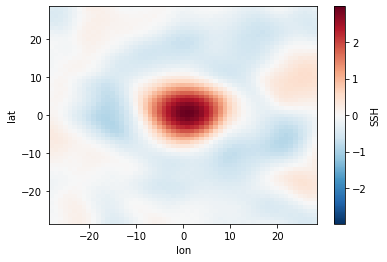

In [11]:
Anticyclonic_monthly['jan']['SSH'].plot()

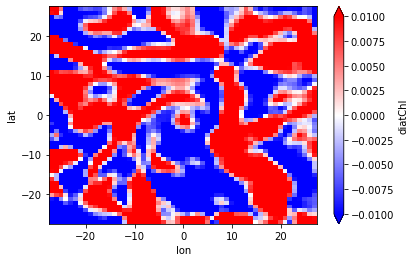

In [12]:
Cyclonic_monthly['jan']['diatChl'].isel(z_t_150m=0).plot(vmin=-0.01,vmax=0.01,cmap='bwr')

### plot January composites

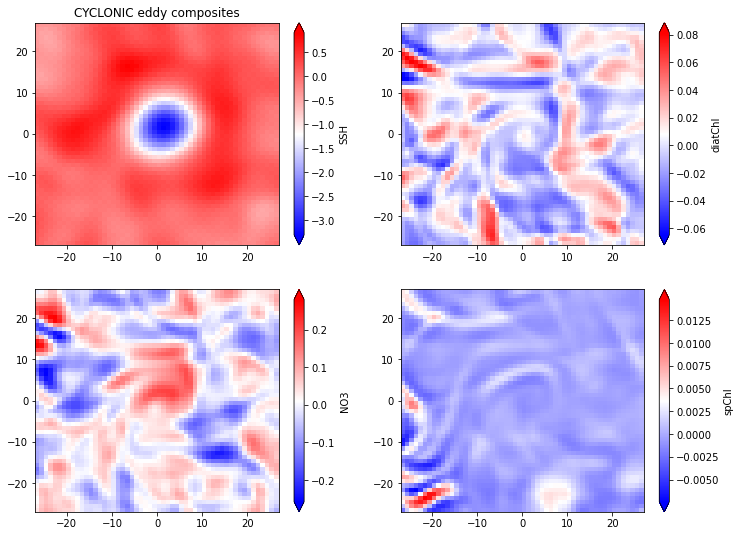

In [13]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('CYCLONIC eddy composites')
    var= Cyclonic_monthly['jan'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Cyclonic_monthly['jan'].lon, Cyclonic_monthly['jan'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
fig.savefig('/glade/u/home/kristenk/feature-centric-composite/figs/reg_lat'+str(lat_min)+'_'+str(lat_max)+'_lon'+str(lon_min)+'_'+str(lon_max)+'.png',dpi=300, bbox_inches='tight',format='png');


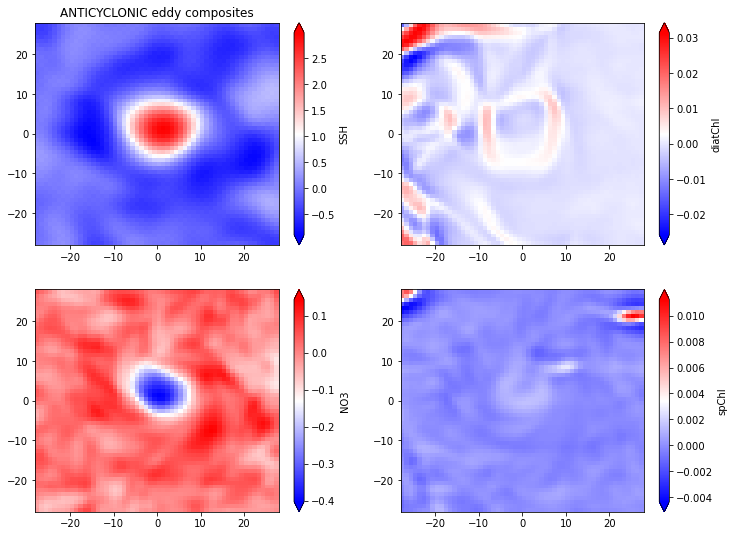

In [14]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('ANTICYCLONIC eddy composites')
    var= Anticyclonic_monthly['jan'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Anticyclonic_monthly['jan'].lon, Anticyclonic_monthly['jan'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

### Plot July composites

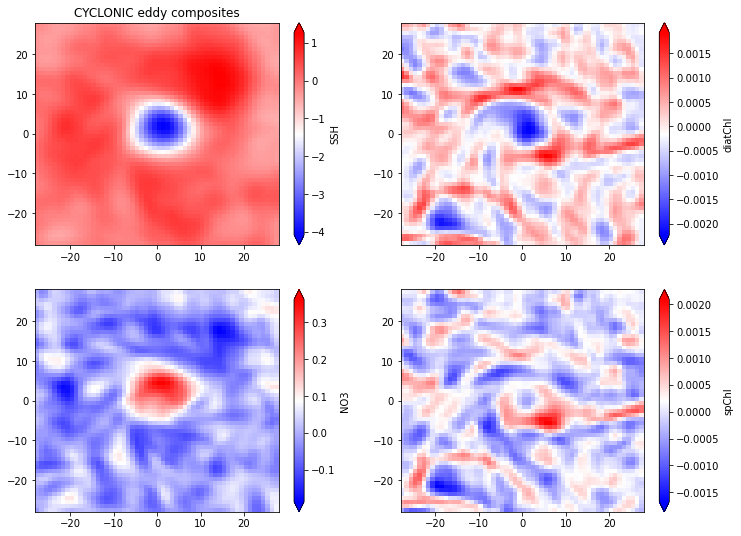

In [15]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('CYCLONIC eddy composites')
    var= Cyclonic_monthly['jul'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Cyclonic_monthly['jul'].lon, Cyclonic_monthly['jul'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

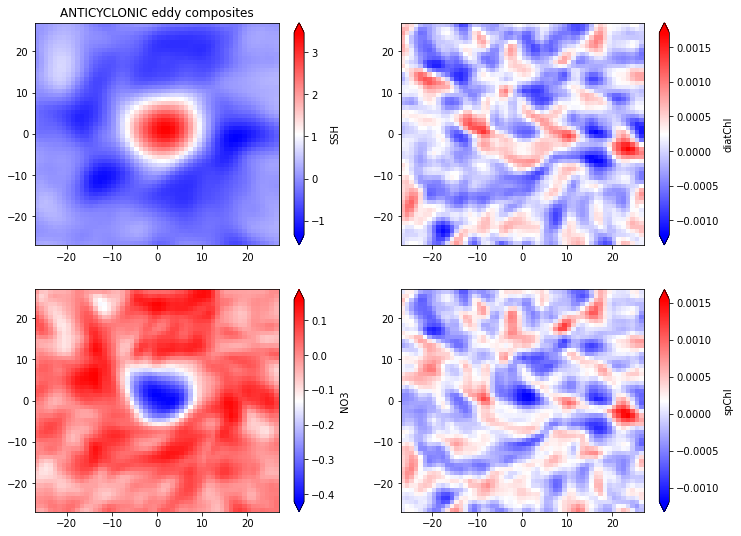

In [16]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('ANTICYCLONIC eddy composites')
    var= Anticyclonic_monthly['jul'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Anticyclonic_monthly['jul'].lon, Anticyclonic_monthly['jul'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

### june composites

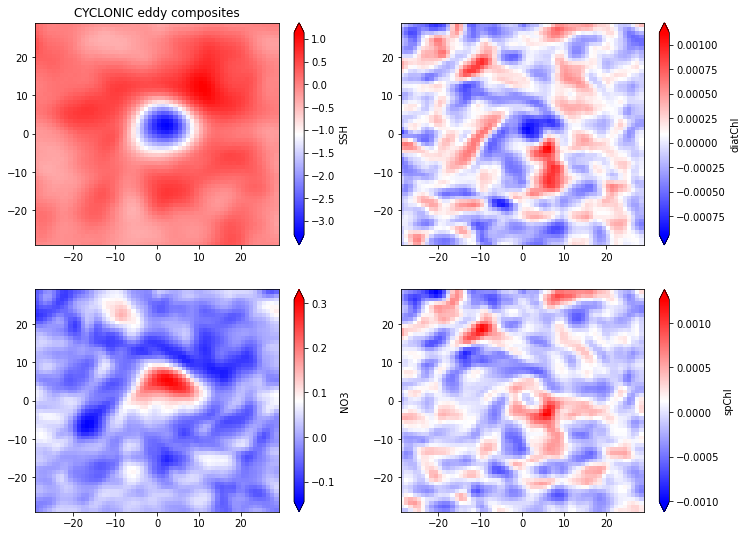

In [17]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('CYCLONIC eddy composites')
    var= Cyclonic_monthly['jun'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Cyclonic_monthly['jun'].lon, Cyclonic_monthly['jun'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

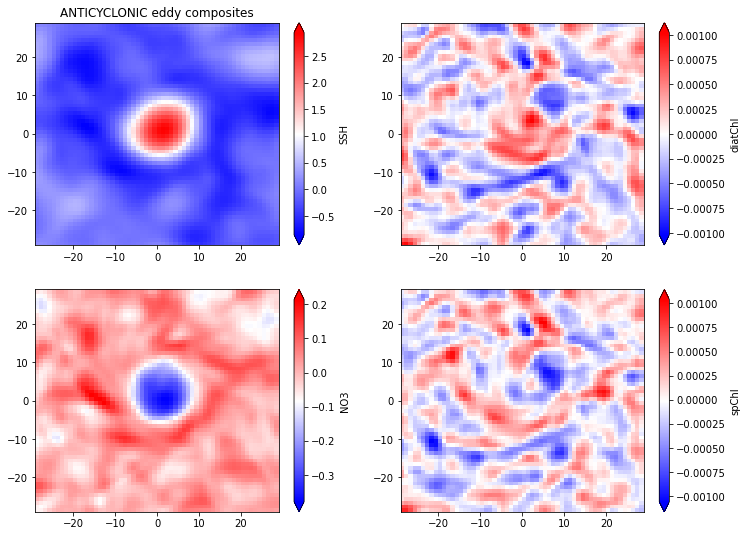

In [18]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('ANTICYCLONIC eddy composites')
    var= Anticyclonic_monthly['jun'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Anticyclonic_monthly['jun'].lon, Anticyclonic_monthly['jun'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

### December composites

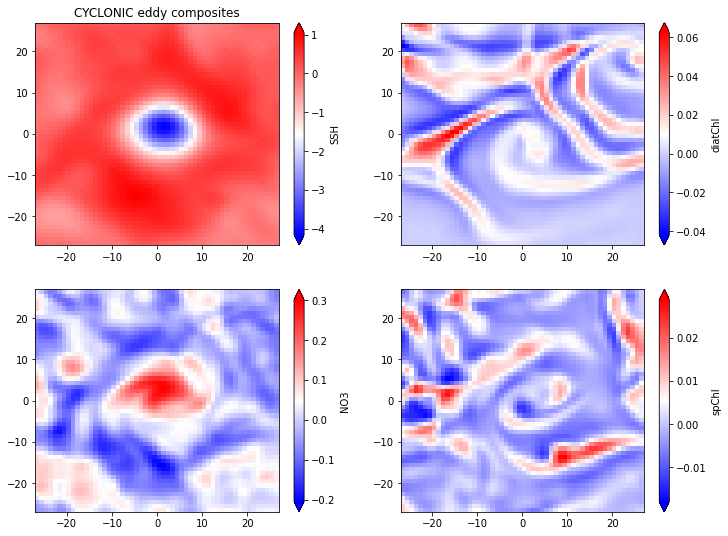

In [19]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('CYCLONIC eddy composites')
    var= Cyclonic_monthly['dec'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Cyclonic_monthly['dec'].lon, Cyclonic_monthly['dec'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

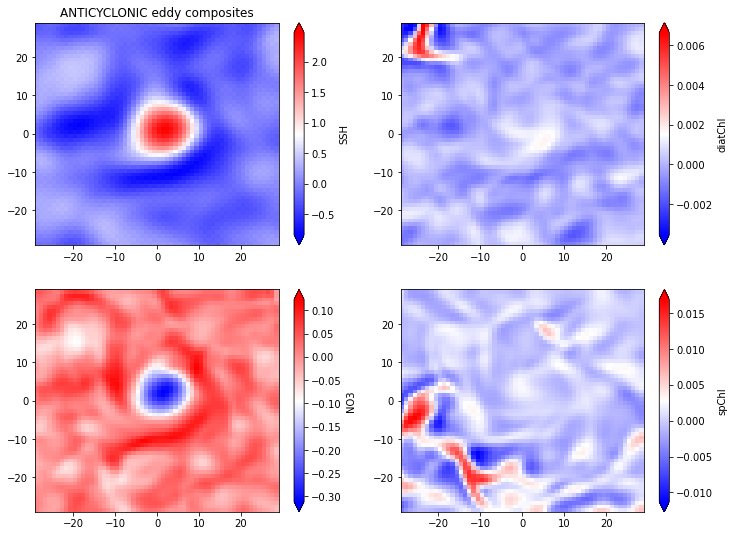

In [20]:
num_comp=len(variables)
fig_width = num_comp * 3
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    if count==1:
        ax.set_title('ANTICYCLONIC eddy composites')
    var= Anticyclonic_monthly['dec'][varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(Anticyclonic_monthly['dec'].lon, Anticyclonic_monthly['dec'].lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

### Vertical section composites

#### January

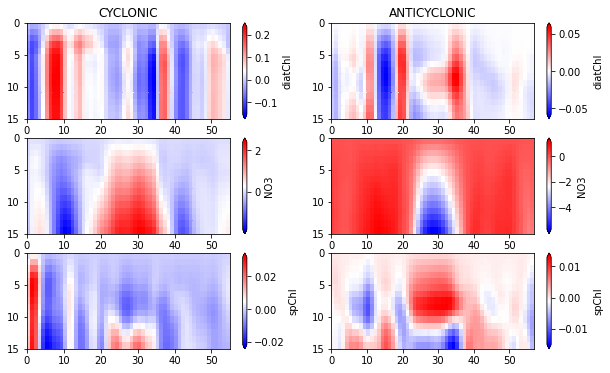

In [21]:
#list of 3d vars

variables=['diatChl','NO3','spChl']

fig_width=10
fig_height=len(variables)*2
rows=len(variables)

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    
    ##### cyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Cyclonic_monthly['jan'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    
    if count==1:
        ax.set_title('CYCLONIC')
    
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    
    ##### anticyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Anticyclonic_monthly['jan'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    if count==2:
        ax.set_title('ANTICYCLONIC')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    

#### July

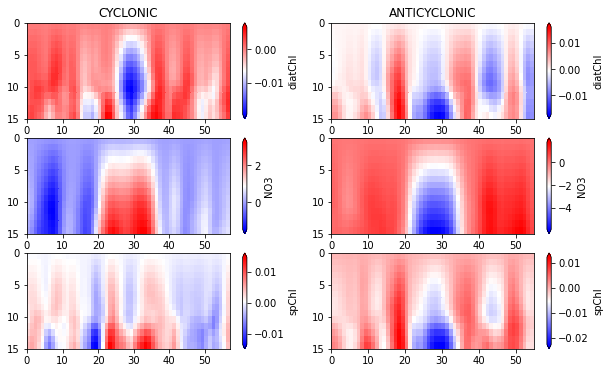

In [22]:
#list of 3d vars

variables=['diatChl','NO3','spChl']

fig_width=10
fig_height=len(variables)*2
rows=len(variables)

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    
    ##### cyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Cyclonic_monthly['jul'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    
    if count==1:
        ax.set_title('CYCLONIC')
    
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    
    ##### anticyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Anticyclonic_monthly['jul'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    if count==2:
        ax.set_title('ANTICYCLONIC')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    

### Dec

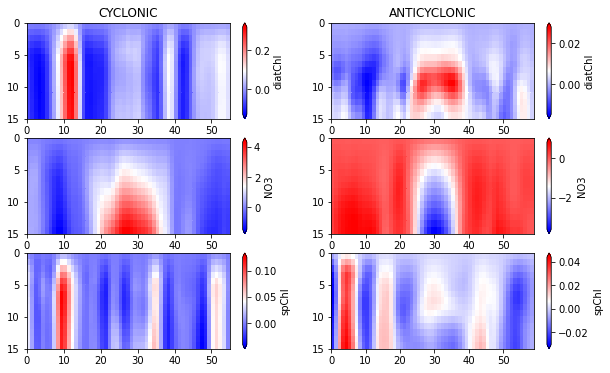

In [23]:
#list of 3d vars

variables=['diatChl','NO3','spChl']

fig_width=10
fig_height=len(variables)*2
rows=len(variables)

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    
    ##### cyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Cyclonic_monthly['dec'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    
    if count==1:
        ax.set_title('CYCLONIC')
    
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    
    ##### anticyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Anticyclonic_monthly['dec'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    if count==2:
        ax.set_title('ANTICYCLONIC')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    

### June

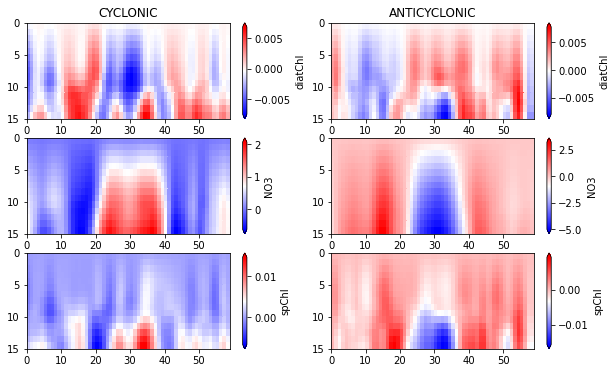

In [24]:
#list of 3d vars

variables=['diatChl','NO3','spChl']

fig_width=10
fig_height=len(variables)*2
rows=len(variables)

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    
    ##### cyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Cyclonic_monthly['jun'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    
    if count==1:
        ax.set_title('CYCLONIC')
    
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    
    ##### anticyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    var= Anticyclonic_monthly['jun'][varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    if count==2:
        ax.set_title('ANTICYCLONIC')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    

### write out data

In [32]:
for varname in vars3d:
    for month_name in ['dec','jun']:
        filename='/glade/work/kristenk/eddy_composite_netcdfs/anticyclonic_'+varname+'_'+month_name+'.nc'
        Anticyclonic_monthly[month_name][varname].to_netcdf(filename)
        filename='/glade/work/kristenk/eddy_composite_netcdfs/cyclonic_'+varname+'_'+month_name+'.nc'
        Cyclonic_monthly[month_name][varname].to_netcdf(filename)

In [47]:
for varname in vars2d:
    for month_name in ['dec','jun']:
        filename='/glade/work/kristenk/eddy_composite_netcdfs/anticyclonic_'+varname+'_'+month_name+'.nc'
        Anticyclonic_monthly[month_name][varname]=xr.DataArray(Anticyclonic_monthly[month_name][varname].values,dims=('lat','lon'))
        Anticyclonic_monthly[month_name][varname].to_netcdf(filename)
        filename='/glade/work/kristenk/eddy_composite_netcdfs/cyclonic_'+varname+'_'+month_name+'.nc'
        Cyclonic_monthly[month_name][varname]=xr.DataArray(Cyclonic_monthly[month_name][varname].values,dims=('lat','lon'))
        Cyclonic_monthly[month_name][varname].to_netcdf(filename)